In [1]:
# Install the required libraries
#!pip install numpy pandas scikit-learn

# Import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import keras
!pip install pydot


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
events_df=pd.read_csv('dataset/events.csv')  
category_df=pd.read_csv('dataset/category_tree.csv')
item_properties_1_df=pd.read_csv('dataset/item_properties_part1.csv')
item_properties_2_df=pd.read_csv('dataset/item_properties_part2.csv')

In [31]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [33]:
events_df[events_df.transactionid.notnull()].event.unique()

array(['transaction'], dtype=object)

In [35]:
events_df[events_df.transactionid.isnull()].event.unique()

array(['view', 'addtocart'], dtype=object)

In [36]:
item_properties_1_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [38]:
category_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [40]:
item_properties_1_df.loc[(item_properties_1_df.property=='categoryid') & (item_properties_1_df.value=='1016')].sort_values('timestamp').head()

,timestamp,itemid,property,value
6363096,1431226800000,339403,categoryid,1016
8597591,1431226800000,161686,categoryid,1016
7942027,1431226800000,418837,categoryid,1016
10230975,1431226800000,85538,categoryid,1016
7280176,1431226800000,278463,categoryid,1016


In [41]:
customer_purchased=events_df[events_df.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

In [42]:
all_customers=events_df.visitorid.unique()
all_customers.size

1407580

In [43]:
customer_browsed=[x for x in all_customers if x not in customer_purchased]

In [44]:
len(customer_browsed)

1395861

In [45]:
customer_purchased[:10]

array([ 599528,  121688,  552148,  102019,  189384,  350566,  404403,
        505565,  945184, 1406787], dtype=int64)

In [46]:
events_df[events_df.visitorid==102019].sort_values('timestamp')

,timestamp,visitorid,event,itemid,transactionid
19690,1433175714335,102019,view,49521,NaN
19501,1433175801314,102019,addtocart,49521,NaN
14842,1433175812596,102019,view,150318,NaN
19573,1433175871497,102019,view,49521,NaN
8701,1433175894837,102019,view,49521,NaN
19708,1433175945872,102019,view,150318,NaN
8740,1433176042269,102019,view,49521,NaN
814,1433176736375,102019,transaction,150318,13556.0
19724,1433176736422,102019,transaction,49521,13556.0


In [49]:
import datetime

tz = int('1433221332')
new_time = datetime.datetime.fromtimestamp(tz)
new_time.strftime('%Y-%m-%d %H:%M:%S')

'2015-06-02 10:32:12'

In [52]:
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()

purchased_items = []

for customer in customer_purchased:
    purchased_items.append(
        events_df.loc[
            (events_df.visitorid == customer) & (events_df.transactionid.notnull()), "itemid"
        ].values
    )


In [53]:
purchased_items[:5]


[array([356475], dtype=int64),
 array([ 15335, 380775, 237753, 317178,  12836, 400969, 105792,  25353,
        200793,  80582, 302422], dtype=int64),
 array([81345], dtype=int64),
 array([150318,  49521], dtype=int64),
 array([310791, 299044], dtype=int64)]

In [93]:
def recommeder_bought_bought(item_id,purchased_items):
  recomender_list=[]
  for x in purchased_items:
    if item_id in x:
      recommender_list +=x

      recommender_list=list(set(recommender_list)-set([item_id]))
      return recommender_list

In [96]:
#recommeder_bought_bought(302422,purchased_items)

In [58]:
all_visitor=events_df.visitorid.sort_values().unique()
all_visitor.size

1407580

In [57]:
buying_visitors=events_df[events_df.event=='transaction'].visitorid.sort_values().unique()
buying_visitors.size

11719

In [60]:
viewing_visitors_list=list(set(all_visitor)-set(buying_visitors))

In [5]:
events.event.replace(to_replace=dict(view=1,addtocart=2,
                                     transaction=3),inplace=True)


In [61]:
def create_dataframe(visitor_list):
    
    array_for_df = []
    for index in visitor_list:

        #Create that visitor's dataframe once
        v_df = events_df[events_df.visitorid == index]

        temp = []
        #Add the visitor id
        temp.append(index)

        #Add the total number of unique products viewed
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)

        #Add the total number of views regardless of product type
        temp.append(v_df[v_df.event == 'view'].event.count())

        #Add the total number of purchases
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)

        #Then put either a zero or one if they made a purchase
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        array_for_df.append(temp)
    
    return pd.DataFrame(array_for_df, columns=['visitorid', 'num_items_viewed', 'view_count', 'bought_count', 'purchased'])

In [62]:
buying_visitors_df = create_dataframe(buying_visitors)
buying_visitors_df.shape

(11719, 5)

In [63]:
import random
random.shuffle(viewing_visitors_list)

In [65]:
viewing_visitors_df=create_dataframe(viewing_visitors_list[0:27820])

In [66]:
viewing_visitors_df.shape

(27820, 5)

In [73]:
main_df = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

In [74]:
main_df=main_df.sample(frac=1)


In [76]:
import seaborn as sns

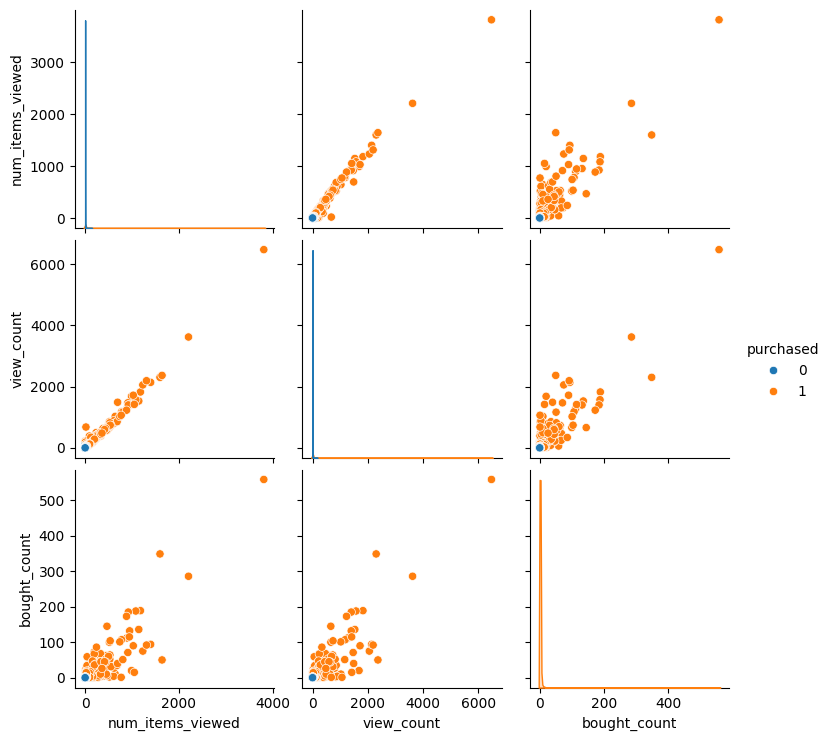

In [77]:
sns.pairplot(main_df,x_vars=['num_items_viewed','view_count','bought_count'],
             y_vars=['num_items_viewed','view_count','bought_count'],hue='purchased') 

In [82]:
X=main_df.drop(['visitorid','purchased','bought_count'],axis=1)
y=main_df.purchased

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.7)

In [ ]:
logreg = LogisticRegression()



LogisticRegression()

In [86]:
logreg.fit(X_train, y_train)


LogisticRegression()

In [87]:
y_pred_class = logreg.predict(X_test)


In [89]:
from sklearn import metrics

print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, y_pred_class)))


accuracy =  0.7950


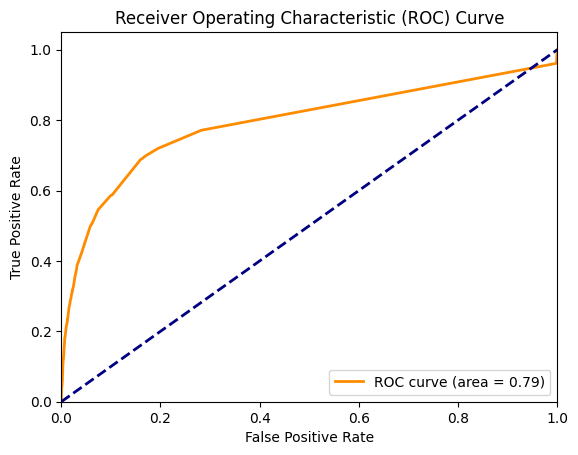

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Ensure that y_test is numeric
y_test = y_test.astype(int)  

# Ensure the model supports probability prediction
if hasattr(logreg, "predict_proba"):
    preds = logreg.predict_proba(X_test)[:, 1]  # Get probability scores for class 1
else:
    raise AttributeError("The model does not support probability prediction.")

# Compute ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Compute AUC
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
